## Image Classification EDA

### import

In [1]:
!pip install plotly statsmodels
!pip install tqdm

You should consider upgrading via the '/Users/ly/.virtualenvs/ml/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/ly/.virtualenvs/ml/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import plotly.express as px

pd.set_option('mode.chained_assignment',  None)

### 변수 선언

In [3]:
data_dir = '../input/data/train'

### pandas를 이용한 train.csv 분석

In [4]:
train_info = pd.read_csv(f'{data_dir}/train.csv')
train_info = train_info.drop('id', axis=1)

#### 결측치 확인
결측치가 없는 것을 확인할 수 있다.

In [5]:
train_info.isnull().sum()

gender    0
race      0
age       0
path      0
dtype: int64

#### train.csv 파일 정보 확인
gender, race, age, path 4가지 feature를 가지고 있으며, 총 2700개의 데이터가 있다.

In [6]:
train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  2700 non-null   object
 1   race    2700 non-null   object
 2   age     2700 non-null   int64 
 3   path    2700 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.5+ KB


gender - male/female 2가지 categorical한 값

race - Asian으로 통일됨

age - 18~60 사이의 자연수값

path - row 데이터와 연관된 folder path

In [7]:
train_info.describe(include='all')

gender   race          age                    path
count     2700   2700  2700.000000                    2700
unique       2      1          NaN                    2700
top     female  Asian          NaN  000001_female_Asian_45
freq      1658   2700          NaN                       1
mean       NaN    NaN    37.708148                     NaN
std        NaN    NaN    16.985904                     NaN
min        NaN    NaN    18.000000                     NaN
25%        NaN    NaN    20.000000                     NaN
50%        NaN    NaN    36.000000                     NaN
75%        NaN    NaN    55.000000                     NaN
max        NaN    NaN    60.000000                     NaN

In [8]:
train_info.sample(10)

gender   race  age                    path
2068    male  Asian   22    005227_male_Asian_22
2289    male  Asian   18    006104_male_Asian_18
1231  female  Asian   20  003196_female_Asian_20
2372  female  Asian   20  006259_female_Asian_20
297   female  Asian   53  000719_female_Asian_53
1235  female  Asian   20  003200_female_Asian_20
634     male  Asian   23    001309_male_Asian_23
1658  female  Asian   58  003834_female_Asian_58
1506    male  Asian   56    003581_male_Asian_56
650   female  Asian   24  001334_female_Asian_24

### 데이터 전처리
1개의 row를 7개로 분리하는 작업(폴더에 총 7가지 데이터가 있어 이를 분리하는 작업)

mask_class: mask 착용상태(wear = 0, incorrect = 1, not wear = 2)에 따라 분리한 class

In [9]:
train_info['mask_class'] = 0
train_info['image_path'] = ''
color_info = pd.DataFrame()

# train_info row 수
data_size = len(train_info)

for i in tqdm(range(data_size)):
    # row folder path 변수 선언
    folder_path = os.listdir(f"{data_dir}/images/{train_info['path'][i]}")
    
    for j in range(len(folder_path)):
        filepath = folder_path[j]
        filename = filepath.split('.')[0]
        
        # mask 착용여부 (0-wear, 1-incorrect, 2-not wear)
        val = 0
        
        if filename == 'incorrect_mask': val = 1
        elif filename == 'normal': val = 2
        
        # 이미지 경로 변수 선언
        image_path = f"images/{train_info['path'][i]}/{filepath}"
        
        # 첫번째 이미지는 원래 dataframe row 데이터 수정
        if j == 0: 
            train_info['mask_class'][i] = val
            train_info['image_path'][i] = image_path
        
        # 나머지 이미지는 새로운 row 생성
        else:
            new_train_series = train_info.iloc[i].copy()
            new_train_series['mask_class'] = val
            new_train_series['image_path'] = image_path
            train_info = train_info.append(new_train_series, ignore_index=True)
            

100%|█████████████████████████████████████████████| 2700/2700 [00:52<00:00, 51.25it/s]


전처리 후 데이터의 개수가 2700에서 18900(2700*7)로 바뀐 것을 확인 가능

In [10]:
len(train_info)

18900

#### 기존 feature class화
age_class: age값들을 0-29, 30-59, 60- 3개 구간으로 분리한 클래스

gender_class: male은 0, female은 1로 분류한 이진 클래스

class: age_class, gender_class, mask_class를 바탕으로 0~17 총 18개로 구분된 클래스

In [11]:
# age class 설정
def age2num(x):
    '''
    age값을 구간을 대표하는 값으로 변환하는 함수
    input: x(Int)
    output: 0[0-29 대표] or 1[30-59 대표] or 2[[60- 대표](Integer)
    '''
    if x >= 60: return 2 # [60, inf)
    elif x >= 30: return 1 # [30, 60)
    return 0 # [0, 30)

train_info['age_class'] = train_info['age'].map(age2num)

# gender class 설정(male=0, female=1)
gender2cat = {'male': 0, 'female': 1}

train_info['gender_class'] = train_info['gender'].map(gender2cat)

# 전체 class 설정(0~17, 총 18개 클래스)
train_info['class'] = train_info['mask_class'] * 6 \
                      + train_info['gender_class'] * 3 \
                      + train_info['age_class']

train_info['age_class'] = train_info['age_class'].astype('category')
train_info['gender_class'] = train_info['gender_class'].astype('category')
train_info['mask_class'] = train_info['mask_class'].astype('category')
train_info['class'] = train_info['class'].astype('category')

train_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gender        18900 non-null  object  
 1   race          18900 non-null  object  
 2   age           18900 non-null  int64   
 3   path          18900 non-null  object  
 4   mask_class    18900 non-null  category
 5   image_path    18900 non-null  object  
 6   age_class     18900 non-null  category
 7   gender_class  18900 non-null  category
 8   class         18900 non-null  category
dtypes: category(4), int64(1), object(4)
memory usage: 813.3+ KB


### 데이터 분석

#### gender 분석
female data가 male data에 비해 1.5배 많은 것을 확인 가능

female    11606
male       7294
Name: gender, dtype: int64


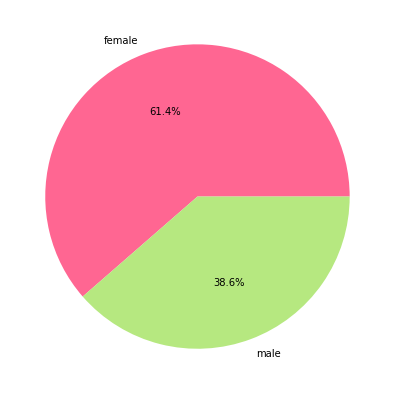

In [12]:
gender_cnt = train_info['gender'].value_counts()
print(gender_cnt)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pie(gender_cnt, 
       labels=['female', 'male'], 
       autopct='%1.1f%%',
       colors=['#FF6692', '#B6E880'])
plt.show()

#### race 분석
Asian 값 하나만이 존재했다.

In [13]:
len(train_info['race'].unique())

1

#### age 분석
(0-29, 30-59, 60-) 3가지 구간으로 분리했다.

60- 구간 데이터의 비율이 적은 것을 확인 가능했다.

0    8967
1    8589
2    1344
Name: age_class, dtype: int64


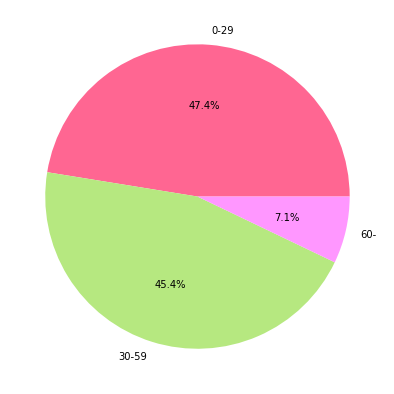

In [14]:
age_cnt = train_info['age_class'].value_counts()
print(age_cnt)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pie(age_cnt, 
       labels=['0-29', '30-59', '60-'], 
       autopct='%1.1f%%',
       colors=['#FF6692', '#B6E880', '#FF97FF'])
plt.show()

#### mask_class 분석
wear(0), incorrect(1), not wear(2)로 구분해 분석했다.

wear 상태가 전체 데이터의 70%, 나머지는 약 14%씩을 차지했다.

0    13500
1     2700
2     2700
Name: mask_class, dtype: int64


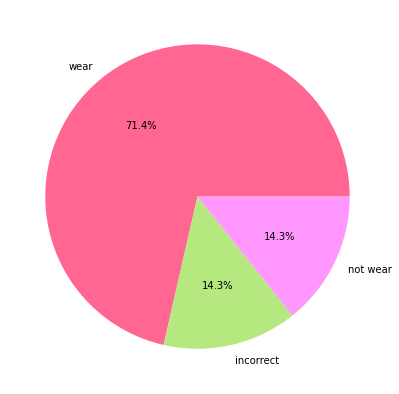

In [15]:
mask_cnt = train_info['mask_class'].value_counts()
print(mask_cnt)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pie(mask_cnt, 
       labels=['wear', 'incorrect', 'not wear'], 
       autopct='%1.1f%%',
       colors=['#FF6692', '#B6E880', '#FF97FF'])
plt.show()

####  class 분석
0~17 총 18개의 클래스별 데이터 개수를 분석했다.
불균형이 눈에 띄었다.

red line plot은 클래스 데이터 개수 평균이다.

0     2745
1     2050
2      415
3     3660
4     4085
5      545
6      549
7      410
8       83
9      732
10     817
11     109
12     549
13     410
14      83
15     732
16     817
17     109
Name: class, dtype: int64


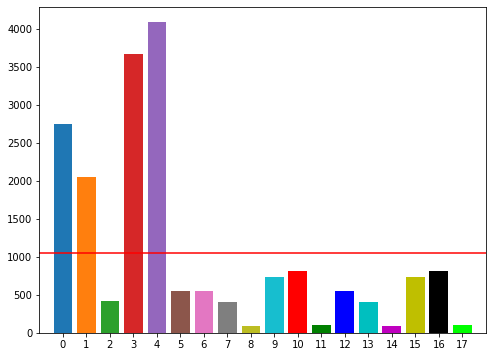

In [16]:
class_cnt = train_info['class'].value_counts().sort_index()
print(class_cnt)

fig, ax = plt.subplots(1, figsize=(8, 6))
ax.bar(class_cnt.index, class_cnt.values, color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','r','g','b','c','m','y','k','lime'])
ax.plot(range(-5, 19), [18900/18]*24, color='r')
ax.set_xticks(range(0,18))
plt.xlim([-1, 18])
plt.show()

In [17]:
train_info = train_info.sort_values(by=['class'], axis=0)

fig = px.histogram(train_info, 
                 x='age',
                 y='gender',
                 color_discrete_sequence=px.colors.qualitative.Light24,
                 color="class",
                 facet_col="age_class",
)

fig.show()

In [18]:
fig = px.scatter_matrix(train_info, 
                 dimensions=['age','gender_class'],
                 color='class',
)

fig.show()

### image 확인해보기

#### 폴더별 이미지 확인해보기
N개의 폴더 내에 있는 데이터들을 확인해보았다.

대부분 구도가 비슷했지만, 이미지마다 명도나 얼굴 각도에 차이가 있었다.

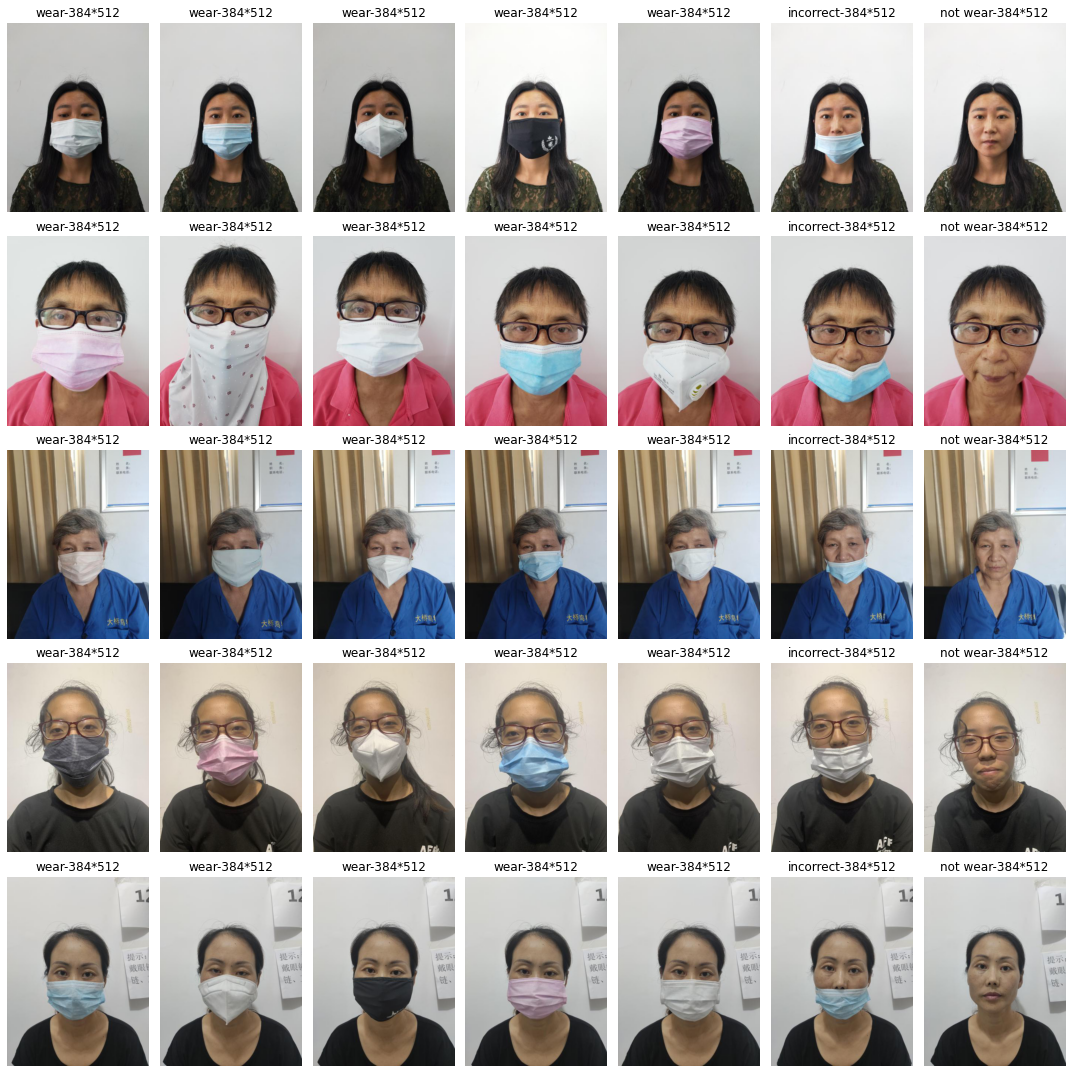

In [19]:
N = 5
image_by_mask_status = np.zeros((3, 3, 512, 384))
class2text = {0: 'wear', 1:'incorrect', 2:'not wear'}

fig, ax = plt.subplots(N, 7, figsize=(5*3, N*3))
path_unique = train_info['path'].unique()
idxs = np.random.choice(len(path_unique), N)
path_list = path_unique[idxs]

for idx in range(N):
    path = path_list[idx]
    image_list = train_info.loc[train_info['path']==path]
    for col in range(len(image_list)):
        image_data = image_list.iloc[col]
        image_class = image_data['mask_class']
        image_path = f"{data_dir}/{image_data['image_path']}"
        image = plt.imread(image_path)
        
        image_by_mask_status[image_class] = image_by_mask_status[image_class] \
                                            + image.transpose((2, 0, 1))
        ax[idx][col].set_title(f'{class2text[image_class]}-{len(image[0])}*{len(image)}')
        ax[idx][col].imshow(image)
        ax[idx][col].axis('off')

plt.tight_layout()

출력한 이미지 데이터에서 mask class에 따른 rgb값 통계를 비교해보았다.

In [20]:
image_by_mask_status[0] = image_by_mask_status[0] / 5
image_by_mask_status = image_by_mask_status / N
image_by_mask_status = image_by_mask_status.transpose((1,0,2,3)).reshape(3, 3, -1)

Red channel 데이터 비교

In [21]:
r_df = pd.DataFrame(image_by_mask_status[0].transpose(), columns = ['wear', 'incorrect', 'not wear'])
r_df.describe()

wear      incorrect       not wear
count  196608.000000  196608.000000  196608.000000
mean      149.943299     156.586433     160.517700
std        50.704531      54.830242      53.813917
min        45.360000      25.400000      28.000000
25%       109.680000     113.000000     121.000000
50%       162.080000     168.200000     175.200000
75%       195.840000     206.600000     209.000000
max       225.800000     234.600000     232.000000

Green channel 데이터 비교

In [22]:
g_df = pd.DataFrame(image_by_mask_status[1].transpose(), columns = ['wear', 'incorrect', 'not wear'])
g_df.describe()

wear      incorrect       not wear
count  196608.000000  196608.000000  196608.000000
mean      142.298278     149.690552     151.409718
std        55.092337      57.978597      59.497256
min        31.240000      28.400000      25.200000
25%        96.200000     102.800000      96.600000
50%       155.120000     159.800000     167.600000
75%       191.560000     201.400000     206.600000
max       224.080000     233.200000     231.600000

Blue channel 데이터 비교

In [23]:
b_df = pd.DataFrame(image_by_mask_status[2].transpose(), columns = ['wear', 'incorrect', 'not wear'])
b_df.describe()

wear      incorrect       not wear
count  196608.000000  196608.000000  196608.000000
mean      139.934442     147.387387     148.105546
std        51.539215      54.422801      58.009957
min        38.600000      36.200000      31.400000
25%        91.600000      98.200000      85.800000
50%       149.920000     157.600000     162.200000
75%       184.840000     194.600000     200.400000
max       216.920000     229.000000     228.000000